In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import urllib.request
import zipfile
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Dropout, Flatten, Input
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import optimizers
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [3]:
# データセット
url = "https://storage.googleapis.com/tutor-contents-dataset.aidemy.jp/6100_gender_recognition_data.zip"
save_name = url.split('/')[-1]

mem = urllib.request.urlopen(url).read()
with open(save_name, mode='wb') as f:
    f.write(mem)

zfile = zipfile.ZipFile(save_name)
zfile.extractall('.')

path_male = os.listdir('./6100_gender_recognition_data/male/')
path_female = os.listdir('./6100_gender_recognition_data/female/')

img_male = []
img_female = []
img_male_path = []
img_female_path = []

# 男性画像読み込み
for i in range(len(path_male)):
    img_path = './6100_gender_recognition_data/male/' + path_male[i]
    img = cv2.imread(img_path)
    b,g,r = cv2.split(img)
    img = cv2.merge([r,g,b])
    img = cv2.resize(img, (32,32))
    img_male.append(img)
    img_male_path.append(img_path)

# 女性画像読み込み
for i in range(len(path_female)):
    img_path = './6100_gender_recognition_data/female/' + path_female[i]
    img = cv2.imread(img_path)
    b,g,r = cv2.split(img)
    img = cv2.merge([r,g,b])
    img = cv2.resize(img, (32,32))
    img_female.append(img)
    img_female_path.append(img_path)

# データ作成
X = np.array(img_male + img_female).astype('float32') / 255.0
y = np.array([0]*len(img_male) + [1]*len(img_female))
img_paths = img_male_path + img_female_path

# データシャッフル
rand_index = np.random.permutation(np.arange(len(X)))
X = X[rand_index]
y = y[rand_index]
img_paths = np.array(img_paths)[rand_index]

# データ分割
X_train = X[:int(len(X)*0.8)]
y_train = y[:int(len(y)*0.8)]
X_test = X[int(len(X)*0.8):]
y_test = y[int(len(y)*0.8):]
img_paths_test = img_paths[int(len(X)*0.8):]

print(f'Train: {len(X_train)}, Test: {len(X_test)}')

Train: 798, Test: 200


In [4]:
# モデル構築 (VGG16転移学習)
input_tensor = Input(shape=(32, 32, 3))
vgg16 = VGG16(include_top=False, weights='imagenet', input_tensor=input_tensor)

top_model = Sequential()
top_model.add(Flatten(input_shape=vgg16.output_shape[1:]))
top_model.add(Dense(256, activation='relu'))
top_model.add(Dense(1, activation='sigmoid'))

# モデル連結
model = Model(inputs=vgg16.input, outputs=top_model(vgg16.output))

# VGG16 の block5_conv 以降を学習可能に
for layer in model.layers[:15]:
    layer.trainable = False
for layer in model.layers[15:]:
    layer.trainable = True

# モデルのコンパイル
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.SGD(learning_rate=1e-4, momentum=0.9),
              metrics=['accuracy'])

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [5]:
# 学習
history = model.fit(X_train, y_train, batch_size=100, epochs=30, validation_data=(X_test, y_test))

Epoch 1/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 10s 566ms/step - accuracy: 0.3814 - loss: 0.7731 - val_accuracy: 0.3650 - val_loss: 0.7610
Epoch 2/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.4094 - loss: 0.7481 - val_accuracy: 0.4250 - val_loss: 0.7384
Epoch 3/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.4503 - loss: 0.7308 - val_accuracy: 0.4700 - val_loss: 0.7167
Epoch 4/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.4948 - loss: 0.7029 - val_accuracy: 0.5200 - val_loss: 0.6955
Epoch 5/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.5247 - loss: 0.6911 - val_accuracy: 0.5800 - val_loss: 0.6771
Epoch 6/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.6049 - loss: 0.6702 - val_accuracy: 0.6300 - val_loss: 0.6615
Epoch 7/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.6319 - loss: 0.6551 - val_accuracy: 0.6500 - val_loss: 0.6472
Epoch 8/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.6332 - loss: 0.6513 - val_accuracy: 0.6500 - val_loss: 0.635

In [6]:
# 評価
scores = model.evaluate(X_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 172ms/step - accuracy: 0.7681 - loss: 0.4838
Test loss: 0.5095155239105225
Test accuracy: 0.7450000047683716


In [7]:
# 推論関数
def pred_gender(img):
    img = cv2.resize(img, (32, 32))
    img = np.array(img).astype('float32') / 255.0
    pred = model.predict(np.array([img]))[0][0]
    if pred < 0.5:
        return 'male'
    else:
        return 'female'

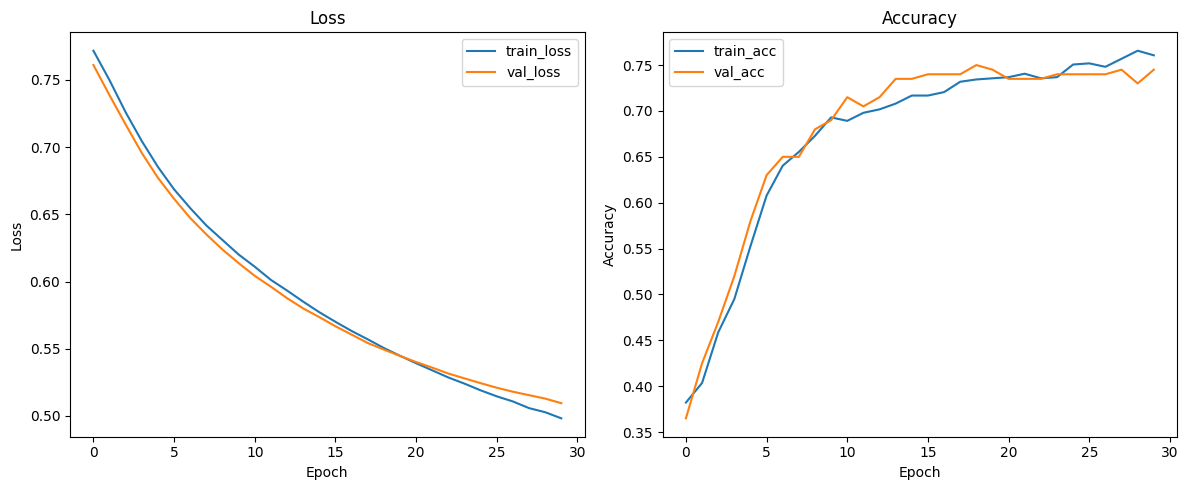

In [8]:
# 学習履歴の可視化
plt.figure(figsize=(12, 5))

# Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


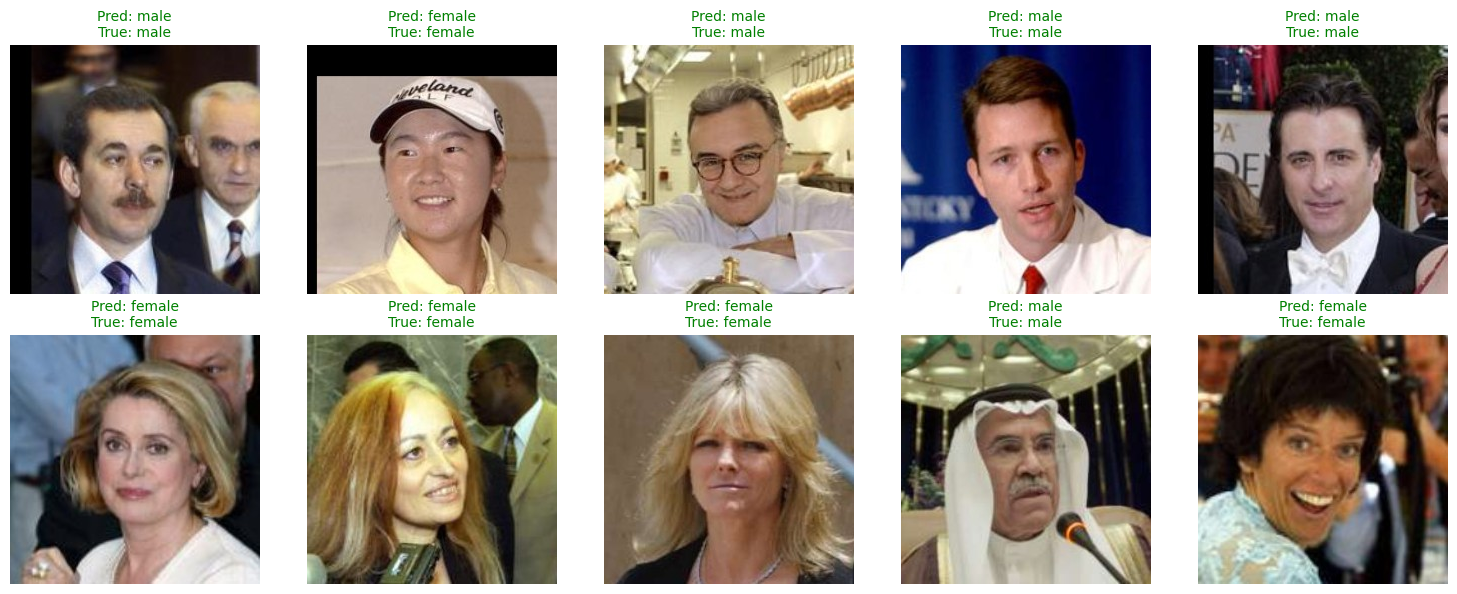

In [9]:
# 混合10枚グリッド表示
n_images = 10
indices = random.sample(range(len(X_test)), n_images)

fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.flatten()

for i, idx in enumerate(indices):
    img_path = img_paths_test[idx]
    true_label = 'male' if y_test[idx] == 0 else 'female'

    img = cv2.imread(img_path)
    b, g, r = cv2.split(img)
    img = cv2.merge([r, g, b])

    pred_label = pred_gender(img)

    axes[i].imshow(img)
    axes[i].axis('off')

    if pred_label == true_label:
        color = 'green'
    else:
        color = 'red'

    axes[i].set_title(f'Pred: {pred_label}\nTrue: {true_label}', color=color, fontsize=10)

# 空き枠非表示
for i in range(n_images, len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.show()

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step


<Figure size 500x500 with 0 Axes>

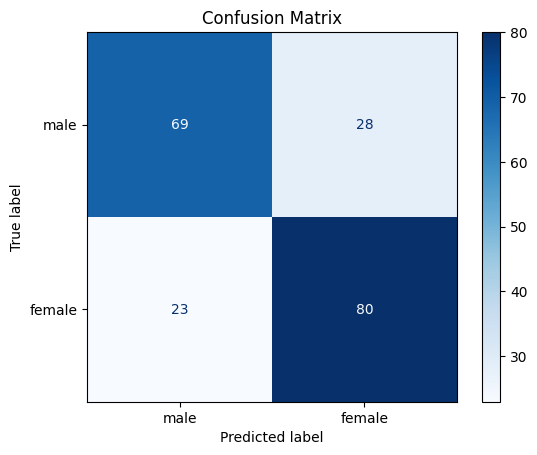

In [10]:
# Confusion Matrix 表示
y_test_pred = model.predict(X_test)
y_test_pred_labels = (y_test_pred > 0.5).astype(int).flatten()

cm = confusion_matrix(y_test, y_test_pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['male', 'female'])

plt.figure(figsize=(5, 5))
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix')
plt.show()